## Business Understanding

This project aims to solve the problem of automatically classifying musical chords as either major or minor using audio input. Chord identification is a key task in music analysis, and automating it can save time on transcription and harmonic analysis. By using machine learning and music information retrieval (MIR) techniques, the goal is to create a tool that helps musicians, producers, and educators analyze music in real-time. The project focuses on making chord recognition more accessible and efficient, benefiting both students and professionals in the music industry.

---

## Tools/Methodologies

To handle the workflow, I'll use several Python libraries:

- [librosa](https://librosa.org/doc/latest/index.html) for extracting audio features, [numpy](https://numpy.org/doc/1.24/reference/index.html#reference) and [pandas](https://pandas.pydata.org/docs/reference/index.html#api) for data manipulation, and os and [Kaggle CLI](https://www.kaggle.com/code/donkeys/kaggle-python-api) to download the data directly into the notebook.
- [matplotlib](https://matplotlib.org/stable/api/index.html) and [seaborn](https://seaborn.pydata.org/api.html) for exploring and visualizing features like waveforms and spectrograms.
- [scikit-learn](https://scikit-learn.org/stable/api/index.html) for baseline models (e.g., logistic regression, SVM), and [tensorflow](https://www.tensorflow.org/api_docs/python/tf/all_symbols) or [keras](https://keras.io/api/) for building CNNs.

In [1]:
# Data manipulation
import numpy as np
import pandas as pd
import sklearn
import json
import os

# Audio feature extraction
import librosa
import soundfile as sf
from scipy.signal import find_peaks

# for Kaggle CLI
from kaggle.api.kaggle_api_extended import KaggleApi

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Machine learning models and utilities
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import KNNImputer

# Deep learning for CNNs
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.utils import to_categorical

## Data Understanding
The dataset used in this project is sourced from the [Musical Instrument Chord Classification (Audio)](https://www.kaggle.com/datasets/deepcontractor/musical-instrument-chord-classification) dataset on Kaggle. It contains audio files `.wav` format of chords played on two instruments: guitar and piano. The raw data has been scraped from various sources and is already available for download on Kaggle, eliminating the need for manual data collection. The dataset is well-suited for this project, as it provides a clear distinction between major and minor chords, which is the focus of the classification task.

The features for the model will be extracted from the audio files using techniques such as Mel-frequency cepstral coefficients (MFCCs) or spectrograms, which capture important frequency and temporal information from the audio signals. Although other individuals may have used this dataset for similar chord classification tasks, this project will build upon existing work by focusing specifically on distinguishing between major and minor chords, potentially improving upon current models or exploring new machine learning techniques for this type of classification.

In [2]:
# uncomment if replicating project
# !pip install kaggle

In [3]:
# Load kaggle.json credentials
api_config_path = os.path.join(os.getcwd(), 'kaggle.json')
with open(api_config_path, 'r') as f:
    kaggle_config = json.load(f)

# Set environment variables
os.environ['KAGGLE_USERNAME'] = kaggle_config['username']
os.environ['KAGGLE_KEY'] = kaggle_config['key']

# Initialize the Kaggle API
api = KaggleApi()
api.authenticate()

# Ensure the 'dataset' folder exists
dataset_dir = os.path.join(os.getcwd(), 'dataset')
os.makedirs(dataset_dir, exist_ok=True)

# Use the Kaggle API to download the dataset
api.dataset_download_files('deepcontractor/musical-instrument-chord-classification',
                           path=dataset_dir, unzip=True)

print("Dataset downloaded and extracted to:", dataset_dir)

Dataset URL: https://www.kaggle.com/datasets/deepcontractor/musical-instrument-chord-classification
Dataset downloaded and extracted to: C:\Users\Nik\Desktop\code\Flatiron\capstone\dataset


In [4]:
# Define the base directory where the audio files are stored
base_dir = os.path.join(os.getcwd(), 'dataset', 'Audio_Files')

# Prepare to collect file details
file_details = []

# Loop through each category directory ('Major' and 'Minor')
for category in ['Major', 'Minor']:
    category_dir = os.path.join(base_dir, category)
    
    for filename in os.listdir(category_dir):
        if filename.endswith('.wav'):
            # Full path to file
            file_path = os.path.join(category_dir, filename)
            # Append the file path, filename (used as ID), and label to the list
            file_details.append({'path': file_path, 'id': filename, 'label': category})

# Save collected file details as a DataFrame
file_data = pd.DataFrame(file_details)

file_data.head()

,path,id,label
0,C:\Users\Nik\Desktop\code\Flatiron\capstone\da...,Major_0.wav,Major
1,C:\Users\Nik\Desktop\code\Flatiron\capstone\da...,Major_1.wav,Major
2,C:\Users\Nik\Desktop\code\Flatiron\capstone\da...,Major_10.wav,Major
3,C:\Users\Nik\Desktop\code\Flatiron\capstone\da...,Major_100.wav,Major
4,C:\Users\Nik\Desktop\code\Flatiron\capstone\da...,Major_101.wav,Major


## Music and Math

Each musical note corresponds to a fundamental frequency - the lowest frequency of a note that is musically pleasing. This frequency is what characterizes the note, which is represented by letters ['A', 'B', 'C', 'D', 'E', 'F', 'G']. 

#### Frequency:

The frequency \( f \) of a note can be calculated with the following formula:

$$ f = f_0 \times 2^{\frac{n}{12}} $$

Where:
- `f_0` is the frequency of a reference note (usually the note **A4**, which is **440 Hz**).
- `n` is the number of half-steps away from the reference note. Positive values of `n` indicate higher notes, while negative values indicate lower notes.

The standard practice in determining the closest note to a given frequency generally involves finding which standard note frequency it's nearest to.

#### Harmonics

A single note played on an instrument does not produce just one frequency. For example, playing an 'A' at 220 Hz will generate additional frequencies at 440 Hz, 660 Hz, 880 Hz, 1100 Hz, and so on. According to this [Music Note Frequency Chart](https://mixbutton.com/mixing-articles/music-note-to-frequency-chart/) the frequencies 220, 440, and 880 Hz correspond to the musical notes A3, A4, and A5, respectively. These notes are all 'A' notes, each one octave apart. The lowest harmonic, known as the fundamental frequency, determines the perceived pitch of the sound.

> In standard musical pitch, A4, or the fourth octave 'A', is tuned to 440 Hz.

Interestingly, the frequency 1100 Hz falls between the frequencies for B5 (987.77 Hz) and C6 (1046.50 Hz). Calculating the midpoint between these two frequencies gives:

$$
\text{Midpoint} = \frac{987.77 \, \text{Hz} + 1046.50 \, \text{Hz}}{2} = 1017.135 \, \text{Hz}
$$

Since 1100 Hz is closer to 1046.50 Hz than to 987.77 Hz, it would be classified closer to C6 in standard musical pitch, though it is somewhat sharper than a typical B5. This illustrates how harmonics work in physical instruments, where playing a fundamental note also produces these higher frequencies, contributing to the richness of the instrument's sound.

#### Chords

A chord represents a combination of several notes played simultaneously, resulting in a harmonious sound. This harmony is achieved through the specific relationship of the frequencies of the notes within the chord. For instance, a simple major chord is composed of the root note, a major third above the root, and a perfect fifth above the root, creating a full and bright sound typically associated with major chords.

Minor chords, on the other hand, are formed by the root note, a minor third above the root, and a perfect fifth above the root, delivering a more melancholic or somber tone compared to major chords.

In addition to major and minor chords, two other common types are diminished and augmented chords. A diminished chord is made up of the root note, a minor third, and a diminished fifth, giving it a tense and unstable sound. An augmented chord consists of the root note, a major third, and an augmented fifth, which creates a sense of suspense or unresolved tension.

#### FourierTransforms

A Fourier transform is a powerful mathematical tool that transforms a signal from its original domain (often time or space) into a frequency domain. This transformation allows us to dissect complex signals and understand how different frequencies contribute to the overall signal. Essentially, it breaks down a wave-like signal into its individual components, highlighting the frequencies that are present.

Why does this help us? Well, by using a Fourier transform, we can analyze various aspects of signals that are not immediately apparent in the time domain. For example, in music production, it helps us identify the specific frequencies that make up a sound, which is crucial for tasks like mixing, mastering, or even sound design. This analysis provides insights into the pitch, tone, and timbre of sounds, helping audio engineers and musicians make informed decisions to enhance musical pieces.

In essence, the Fourier transform is a bridge between the time domain and the frequency domain, providing a comprehensive look at the frequencies that influence a signal. This capability makes it an indispensable tool in fields ranging from audio processing to telecommunications and beyond.

Using a frequency chart to analyze these chords would reveal a complex spectrum due to the concurrent presence of multiple notes. Each note in a chord contributes its fundamental frequency along with its harmonics, leading to a dense array of spikes on the chart. This complex interplay of frequencies helps to understand why chords have their distinctive sounds and emotional impacts.

### Spectogram

A **spectrogram** is a visual representation of the spectrum of frequencies in a sound or other signal as they vary with time. It's essentially a graph that shows the intensity (or loudness) of various frequencies over a period of time. The horizontal axis of a spectrogram represents time, the vertical axis represents frequency, and the colors or shades on the graph indicate the amplitude or strength of the frequencies at any given time. 

#### Why are they useful?

- **Analysis of Sounds**: Spectrograms are incredibly useful for analyzing the characteristics of different sounds, making them indispensable in fields like music production, linguistics, and sound engineering. They help identify variations in frequency that occur over time, which can be crucial for understanding speech patterns, musical notes, and environmental sounds.
- **Signal Processing**: In signal processing, spectrograms provide a clear visualization of how frequencies change, aiding in the enhancement or isolation of specific sounds within a mixed signal.
- **Troubleshooting**: They are also used to diagnose issues in machinery or systems by detecting unusual frequency patterns, which often indicate malfunctions.

In [5]:
from IPython.display import Audio

# To visualize audio data
from scipy.fft import fft
from scipy.io import wavfile

In [6]:
class AudioAnalyzer:
    def __init__(self, df):
        self.df = df

    def play_audio(self, file_id):
        row = self.df.iloc[file_id]
        filename = row['path']
        return Audio(filename)

    def plot_audio(self, file_id, max_freq=None):
        row = self.df.iloc[file_id]
        filename = row['path']
        
        # Read the audio file
        samplerate, data = wavfile.read(filename)
        times = np.arange(len(data)) / float(samplerate)
        
        # Plot time domain data
        plt.figure(figsize=(16, 6))
        plt.subplot(1, 2, 1)
        plt.title("Time Domain")
        plt.xlabel("Time [s]")
        plt.ylabel("Amplitude")
        plt.plot(times, data)
        
        # Compute and plot frequency domain data
        fft_data = np.fft.fft(data)
        freqs = np.fft.fftfreq(len(fft_data), 1/samplerate)
        magnitude = np.abs(fft_data)[:len(data)//2]
        freqs = freqs[:len(data)//2]
        
        plt.subplot(1, 2, 2)
        plt.title("Frequency Domain")
        plt.xlabel("Frequency [Hz]")
        plt.ylabel("Magnitude")
        if max_freq is not None:
            plt.xlim([0, max_freq])
        plt.plot(freqs, magnitude)
        plt.show()
        
    def plot_spectrogram(self, file_id, max_freq=None):
        row = self.df.iloc[file_id]
        filename = row['path']
        signal, sr = librosa.load(filename, sr=None)  # Load with the original sample rate

        # Generate the spectrogram
        D = librosa.amplitude_to_db(np.abs(librosa.stft(signal)), ref=np.max)

        # Plotting the spectrogram
        plt.figure(figsize=(10, 4))
        librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
        if max_freq is not None:
            plt.ylim([0, max_freq])
        plt.colorbar(format='%+2.0f dB')
        plt.title('Spectrogram')
        plt.xlabel('Time')
        plt.ylabel('Frequency (Hz)')
        plt.tight_layout()
        plt.show()

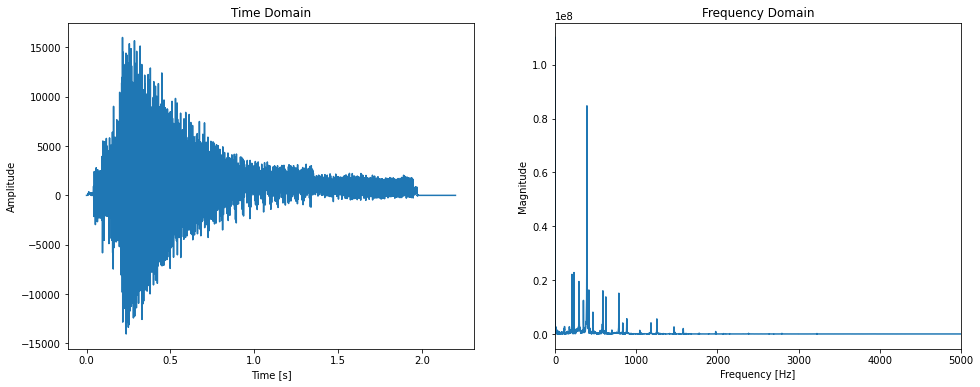

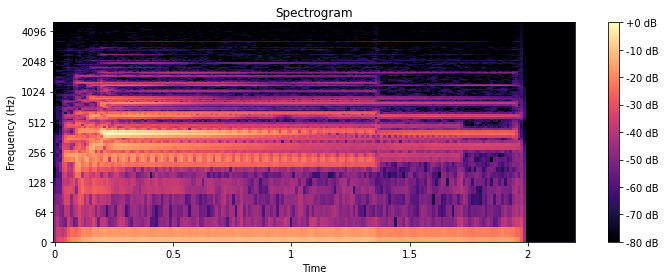

In [7]:
analyzer = AudioAnalyzer(file_data)
file_id = 440 #up to 858

# Play the audio
audio_player = analyzer.play_audio(file_id)
audio_player

# Plot the audio
analyzer.plot_audio(file_id, max_freq=5000)
analyzer.plot_spectrogram(file_id, max_freq=5000)

### Model Iterations:

#### Model v1:

First, I wanted to to compare the extract_features method I used in my [last project]() (mostly out of curiosity :p)

This included extracting features like:
- **Chroma Features**: calculated using the short-time Fourier transform (STFT) of the audio file. Chroma features capture the essence of the pitch content within each octave group - which is vital for chord identification.
- **MFCCs**: used to capture the timbral aspects of an audio signal. (This is what makes a song or chord 'feel' a certain way!) The first few coefficients especially provide a good representation of the overall spectral shape which is influenced by the harmonic structure of the chord.

These features were fed into a Convolutional Neural Network (CNN):

| Class | Precision | Recall | F1-score | Support |
|-------|-----------|--------|----------|---------|
| Major | 0.53      | 1.00   | 0.70     | 46      |
| Minor | 0.00      | 0.00   | 0.00     | 40      |
| **accuracy** | | | 0.53 | 86 |
| **macro avg** | 0.27 | 0.50 | 0.35 | 86 |
| **weighted avg** | 0.29 | 0.53 | 0.37 | 86 |

This is alarming - our scores for precision, recall, and f1-score for the Minor class are ALL zero. 
This is probably because we are focusing in on timbral aspects of the audio, rather than the individual frequencies of the notes in the chords. But an interesting first model!


#### Model v2:

After implementing a new feature extraction method to (instead) extract harmonics, these are the results of a simple Logistic Regression as a baseline classifier.

Accuracy: 60.47%

Classification Report (Harmonics & Simple Logistic Regression):

|               | precision | recall | f1-score | support |
|---------------|------------|--------|----------|---------|
| **Major**     | 0.63       | 0.81   | 0.71     | 101     |
| **Minor**     | 0.54       | 0.31   | 0.39     | 71      |
| **accuracy**  |            |        | 0.60     | 172     |
| **macro avg** | 0.58       | 0.56   | 0.55     | 172     |
| **weighted avg** | 0.59    | 0.60   | 0.58     | 172     |

Confusion Matrix:

[[82 19]

 [49 22]]
 
 
  Lets try a more advanced models:
 
 #### Model v3:
 
Support Vector Machine (SVM): 58.14%
              precision    recall  f1-score   support

       Major       0.60      0.83      0.70       101
       Minor       0.48      0.23      0.31        71

    accuracy                           0.58       172
   macro avg       0.54      0.53      0.50       172
weighted avg       0.56      0.58      0.54       172

[[84 17]

 [55 16]]

#### Model v4:

Random Forest Accuracy: 69.19%
              precision    recall  f1-score   support

       Major       0.76      0.70      0.73       101
       Minor       0.62      0.68      0.64        71

    accuracy                           0.69       172
   macro avg       0.69      0.69      0.69       172
weighted avg       0.70      0.69      0.69       172

[[71 30]

 [23 48]]
 
 
#### Model v5:

Neural Network Accuracy: 62.79%
              precision    recall  f1-score   support

       Major       0.63      0.89      0.74       101
       Minor       0.62      0.25      0.36        71

    accuracy                           0.63       172
   macro avg       0.63      0.57      0.55       172
weighted avg       0.63      0.63      0.58       172

Confusion Matrix for Neural Network:

[[90 11]

 [53 18]]
 
#### Model v6:

Now, using feature engineering to only train with features that will be useful for the model!

Random Tree (with feature engineering):
              precision    recall  f1-score   support

       Major       0.82      0.91      0.86        98
       Minor       0.86      0.73      0.79        74

    accuracy                           0.83       172
   macro avg       0.84      0.82      0.82       172
weighted avg       0.83      0.83      0.83       172

Confusion Matrix:

[[89  9]

[20 54]]


#### Model v7:

A lot of audio classification will rely on the MFCCS ( explain later lol ), so I also wanted to attempt combining my original model's method of extracting features with the previous model's feature engineering of the harmonics method. 

Classification Report:
              precision    recall  f1-score   support

       Major       0.74      0.92      0.82        98
       Minor       0.84      0.58      0.69        74

    accuracy                           0.77       172
   macro avg       0.79      0.75      0.75       172
weighted avg       0.79      0.77      0.76       172

Confusion Matrix:
[[90  8]
 [31 43]]


#### Model v8:

Neural Network for the same group of features. 

Classification Report:
              precision    recall  f1-score   support

       Major       0.71      0.82      0.76        98
       Minor       0.69      0.55      0.62        74

    accuracy                           0.70       172
   macro avg       0.70      0.69      0.69       172
weighted avg       0.70      0.70      0.70       172

Confusion Matrix:

[[80 18]

 [33 41]]
 
#### Model v9:

While harmonic frequencies and intervals between them are useful, the way they relate to major vs minor chords could be more nuanced than just the interval values (like we are using). Major and minor chords differ mainly in the 3rd interval (major third vs minor third). We will focus on specific intervals or harmonic relationships that are known to differentiate major and minor chords.

We will compute the ratio between the 1st harmonic and the 3rd harmonic for each chord - and use that as a new feature. 

Classification Report:
              precision    recall  f1-score   support

       Major       0.77      0.81      0.79        97
       Minor       0.74      0.69      0.72        75

    accuracy                           0.76       172
   macro avg       0.76      0.75      0.76       172
weighted avg       0.76      0.76      0.76       172

Confusion Matrix:

[[79 18]

 [23 52]]


####

---

## Data Preparation

The dataset consists of raw .wav files, so no traditional tabular data is available. Preprocessing will involve extracting features like MFCCs, spectrograms, or chroma features to transform the audio into usable data. Challenges include ensuring that these features correctly capture the harmonic information while handling variations in recording quality and instrument type. We estimate several hundred rows of data, each representing an individual chord sample. Visualizations like waveform plots and spectrograms will be used to explore the features that distinguish major from minor chords.

### Extract Features

#### Audio features:

Using the `extract_audio_features` method, we will extract:
- mfccs and such bla bla bla

We will also normalize the data in this step.

Just like we did in our first model.

#### Harmonics and Intervals

Using the find_harmonics and selected features from our [Feature Engineering] section

#### Encode Labels
Our target feature 'label' should be converted into a numerical format.
> 0: Major 
> 1: Minor

In [8]:
def extract_audio_features(file_path, sr=22050, hop_length=512, n_fft=2048):
    try:
        # Load the audio file
        y, sr = librosa.load(file_path, sr=sr)
        
        # Extract features with default fallback values if extraction fails
        chroma = librosa.feature.chroma_stft(y=y, sr=sr, hop_length=hop_length, n_fft=n_fft).mean(axis=1) \
            if len(y) > 0 else np.full(12, np.nan)  # 12 chroma features
        
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20, hop_length=hop_length, n_fft=n_fft).mean(axis=1) \
            if len(y) > 0 else np.full(20, np.nan)  # 20 MFCCs
        
        spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr, hop_length=hop_length).mean() \
            if len(y) > 0 else np.nan
        
        zero_crossing_rate = librosa.feature.zero_crossing_rate(y, hop_length=hop_length).mean() \
            if len(y) > 0 else np.nan
        
        # Return a dictionary with the features
        return {
            'chroma': chroma,
            'mfcc': mfccs,
            'spectral_centroid': spectral_centroid,
            'zero_crossing_rate': zero_crossing_rate
        }
    
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return {
            'chroma': np.full(12, np.nan),
            'mfcc': np.full(20, np.nan),
            'spectral_centroid': np.nan,
            'zero_crossing_rate': np.nan
        }

In [9]:
feature_data = []

# Extract features for each file and store them in a list
for index, row in file_data.iterrows():
    features = extract_audio_features(row['path'])
    
    if features is not None:
        feature_data.append({
            'id': row['id'].replace('.wav', ''),
            'Label': row['label'],
            'chroma': features['chroma'],  # Store chroma features
            'mfcc': features['mfcc'],      # Store MFCC features
            'spectral_centroid': features['spectral_centroid'],  # Store spectral centroid
            'zero_crossing_rate': features['zero_crossing_rate'] # Store zero-crossing rate
        })

# Prepare a list to hold each row's dictionary
feature_dict_list = []

# Determine the number of chroma and MFCC coefficients (12 chroma, 20 MFCCs)
n_chroma = 12
n_mfcc = 20

# Processing each item's features to create a flat dictionary
for item in feature_data:
    feature_dict = {
        'id': item['id'],
        'Label': item['Label']
    }
    
    # Store chroma features
    for i in range(n_chroma):
        feature_dict[f'chroma_{i+1}'] = item['chroma'][i] if i < len(item['chroma']) else np.nan
    
    # Store MFCC features
    for i in range(n_mfcc):
        feature_dict[f'mfcc_{i+1}'] = item['mfcc'][i] if i < len(item['mfcc']) else np.nan
    
    # Store spectral centroid and zero-crossing rate as scalar features
    feature_dict['spectral_centroid'] = item['spectral_centroid']
    feature_dict['zero_crossing_rate'] = item['zero_crossing_rate']
    
    feature_dict_list.append(feature_dict)

# Create a new DataFrame from the list of dictionaries
features_df = pd.DataFrame(feature_dict_list)

# Display the first few rows of the new DataFrame to verify
print(features_df.head())

<ipython-input-8-193616f516a6>:4: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=sr)
H:\Anaconda\envs\learn-env\lib\site-packages\librosa\core\audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Error processing C:\Users\Nik\Desktop\code\Flatiron\capstone\dataset\Audio_Files\Major\Major_285.wav: 
          id  Label  chroma_1  chroma_2  chroma_3  chroma_4  chroma_5  \
0    Major_0  Major  0.742913  0.204407  0.173953  0.280547  0.802854   
1    Major_1  Major  0.729958  0.307365  0.092075  0.152823  0.467690   
2   Major_10  Major  0.383773  0.197410  0.057362  0.069614  0.227125   
3  Major_100  Major  0.223433  0.931608  0.578779  0.638870  0.234647   
4  Major_101  Major  0.137541  0.349761  0.289738  0.445542  0.294066   

   chroma_6  chroma_7  chroma_8  ...   mfcc_13    mfcc_14    mfcc_15  \
0  0.172853  0.121578  0.434359  ... -1.233236   2.531613  -9.903286   
1  0.221199  0.145914  0.392128  ... -5.643203  -4.957089  -3.354305   
2  0.297883  0.736757  0.224346  ... -2.584889 -16.698959 -21.908617   
3  0.322008  0.154993  0.370598  ... -7.823734  -6.011680 -10.768335   
4  0.478135  0.327209  0.586636  ...  3.361689   0.215648  -6.416312   

     mfcc_16    mfcc_17  

In [10]:
warnings.filterwarnings("ignore", category=UserWarning, module="librosa")
warnings.filterwarnings("ignore", category=FutureWarning, module="librosa")

def find_harmonics(file_path, sr=22050, n_fft=2048):
    try:
        # Try to load with soundfile
        y, sr = sf.read(file_path)

        # If y is stereo, convert to mono
        if len(y.shape) > 1:
            y = np.mean(y, axis=1)

    except Exception as e:
        print(f"Error processing {file_path} with soundfile: {e}. Trying with librosa...")

        # Fallback to librosa if soundfile fails
        try:
            y, sr = librosa.load(file_path, sr=sr)
        except Exception as e:
            print(f"Error loading {file_path} with librosa: {e}. Skipping file...")
            return None, None

    # Proceed with harmonic extraction if loading was successful
    try:
        # Perform STFT to get the frequency spectrum
        S = np.abs(librosa.stft(y, n_fft=n_fft))

        # Sum over time frames to get the overall magnitude spectrum
        magnitude = np.mean(S, axis=1)

        # Frequency bins corresponding to the FFT
        frequency = np.fft.fftfreq(len(magnitude), 1/sr)

        # Only keep positive frequencies
        positive_freq_idxs = np.where(frequency >= 0)
        positive_freqs = frequency[positive_freq_idxs]
        positive_magnitude = magnitude[positive_freq_idxs]

        # Find peaks in the frequency spectrum (harmonics)
        peaks, _ = find_peaks(positive_magnitude, height=np.max(positive_magnitude) * 0.1)

        # Get the corresponding frequencies of the peaks (harmonic frequencies)
        harmonic_frequencies = positive_freqs[peaks]

        # Calculate intervals between harmonic frequencies
        harmonic_intervals = np.diff(harmonic_frequencies)

        # Return both harmonic frequencies and intervals
        return harmonic_frequencies, harmonic_intervals

    except Exception as e:
        print(f"Error processing harmonics for {file_path}: {e}")
        return None, None

In [11]:
warnings.simplefilter("ignore", UserWarning)

harmonics_data = []
skipped_files = []  # Initialize list to track skipped files

# Extracting harmonics for each file and storing them in a list
for index, row in file_data.iterrows():
    harmonic_frequencies, harmonic_intervals = find_harmonics(row['path'])
    
    if harmonic_frequencies is not None:
        harmonics_data.append({
            'id': row['id'].replace('.wav', ''),
            'Label': row['label'],
            'harmonics': harmonic_frequencies,
            'intervals': harmonic_intervals
        })
    else:
        print(f"Skipped file: {row['path']}")
        skipped_files.append(row['path'])

# Ensure there are harmonics extracted
if harmonics_data:
    # Find the maximum number of harmonic frequencies across all files
    max_harmonics = max(len(item['harmonics']) for item in harmonics_data)

    # Prepare a list to hold each row's dictionary
    harmonics_dict_list = []

    for item in harmonics_data:
        harmonic_dict = {
            'id': item['id'],
            'Label': item['Label']
        }

        # Fill harmonic frequencies, and pad with NaN if there are fewer than max_harmonics
        for i in range(max_harmonics):
            harmonic_dict[f'harmonic_{i+1}'] = item['harmonics'][i] if i < len(item['harmonics']) else np.nan

        # Optionally, add intervals if you want them as well
        if item['intervals'] is not None:
            for i in range(len(item['intervals'])):
                harmonic_dict[f'interval_{i+1}'] = item['intervals'][i]

        harmonics_dict_list.append(harmonic_dict)

    # Create a new DataFrame from the list of dictionaries
    harmonics_df = pd.DataFrame(harmonics_dict_list)
    print(harmonics_df.head())

else:
    print("No harmonics were extracted from the files.")

# Print skipped files if any
if skipped_files:
    print("\nSkipped files:")
    for file in skipped_files:
        print(file)
else:
    print("\nNo files were skipped.")


Error processing C:\Users\Nik\Desktop\code\Flatiron\capstone\dataset\Audio_Files\Major\Major_285.wav with soundfile: Error opening 'C:\\Users\\Nik\\Desktop\\code\\Flatiron\\capstone\\dataset\\Audio_Files\\Major\\Major_285.wav': Format not recognised.. Trying with librosa...
Error loading C:\Users\Nik\Desktop\code\Flatiron\capstone\dataset\Audio_Files\Major\Major_285.wav with librosa: . Skipping file...
Skipped file: C:\Users\Nik\Desktop\code\Flatiron\capstone\dataset\Audio_Files\Major\Major_285.wav
          id  Label  harmonic_1  harmonic_2  harmonic_3  harmonic_4  \
0    Major_0  Major  258.146341  387.219512  516.292683  645.365854   
1    Major_1  Major  387.219512  516.292683  645.365854  774.439024   
2   Major_10  Major  258.146341  387.219512  516.292683  731.414634   
3  Major_100  Major  301.170732  387.219512  602.341463  774.439024   
4  Major_101  Major  301.170732  387.219512  688.390244  946.536585   

    harmonic_5   harmonic_6   harmonic_7   harmonic_8  ...  interval_

---

## Feature Engineering

Our first couple model iterations used all frequency peaks to train the model, resulting in ~ 65% accuracy. Let's do some exploratory analysis and feature engineering to only pull the frequencies that matter to the note being heard, and not the extra harmonics generated by the instrtument. 

#### Harmonics and Intervals

In [12]:
print(harmonics_df.columns)

Index(['id', 'Label', 'harmonic_1', 'harmonic_2', 'harmonic_3', 'harmonic_4',
       'harmonic_5', 'harmonic_6', 'harmonic_7', 'harmonic_8', 'harmonic_9',
       'harmonic_10', 'harmonic_11', 'harmonic_12', 'harmonic_13',
       'harmonic_14', 'harmonic_15', 'harmonic_16', 'harmonic_17',
       'harmonic_18', 'harmonic_19', 'harmonic_20', 'harmonic_21',
       'interval_1', 'interval_2', 'interval_3', 'interval_4', 'interval_5',
       'interval_6', 'interval_7', 'interval_8', 'interval_9', 'interval_10',
       'interval_11', 'interval_12', 'interval_13', 'interval_14',
       'interval_15', 'interval_16', 'interval_17', 'interval_18',
       'interval_19', 'interval_20'],
      dtype='object')


In [13]:
harmonic_columns = [col for col in harmonics_df.columns if 'harmonic_' in col]
num_harmonics = len(harmonic_columns)

interval_columns = [col for col in harmonics_df.columns if 'interval_' in col]
num_intervals = len(interval_columns)

In [14]:
# Summary statistics 
harmonic_summary = harmonics_df[harmonic_columns].describe()
print(harmonic_summary)

       harmonic_1  harmonic_2  harmonic_3   harmonic_4   harmonic_5  \
count  858.000000  858.000000  858.000000   858.000000   854.000000   
mean   285.074194  455.817841  607.656831   772.182500   957.620152   
std     84.642965   94.573449  111.200934   160.798871   183.126496   
min    172.097561  258.146341  344.195122   430.243902   516.292683   
25%    215.121951  387.219512  516.292683   645.365854   817.463415   
50%    301.170732  473.268293  602.341463   731.414634   946.536585   
75%    344.195122  516.292683  688.390244   860.487805  1032.585366   
max    559.317073  731.414634  989.560976  1850.048780  1850.048780   

        harmonic_6   harmonic_7   harmonic_8   harmonic_9  harmonic_10  ...  \
count   825.000000   752.000000   651.000000   549.000000   474.000000  ...   
mean   1153.940222  1343.081863  1543.590873  1757.260296  2001.995678  ...   
std     214.690490   253.130953   290.329033   315.792069   341.088585  ...   
min     602.341463   774.439024   903.512195

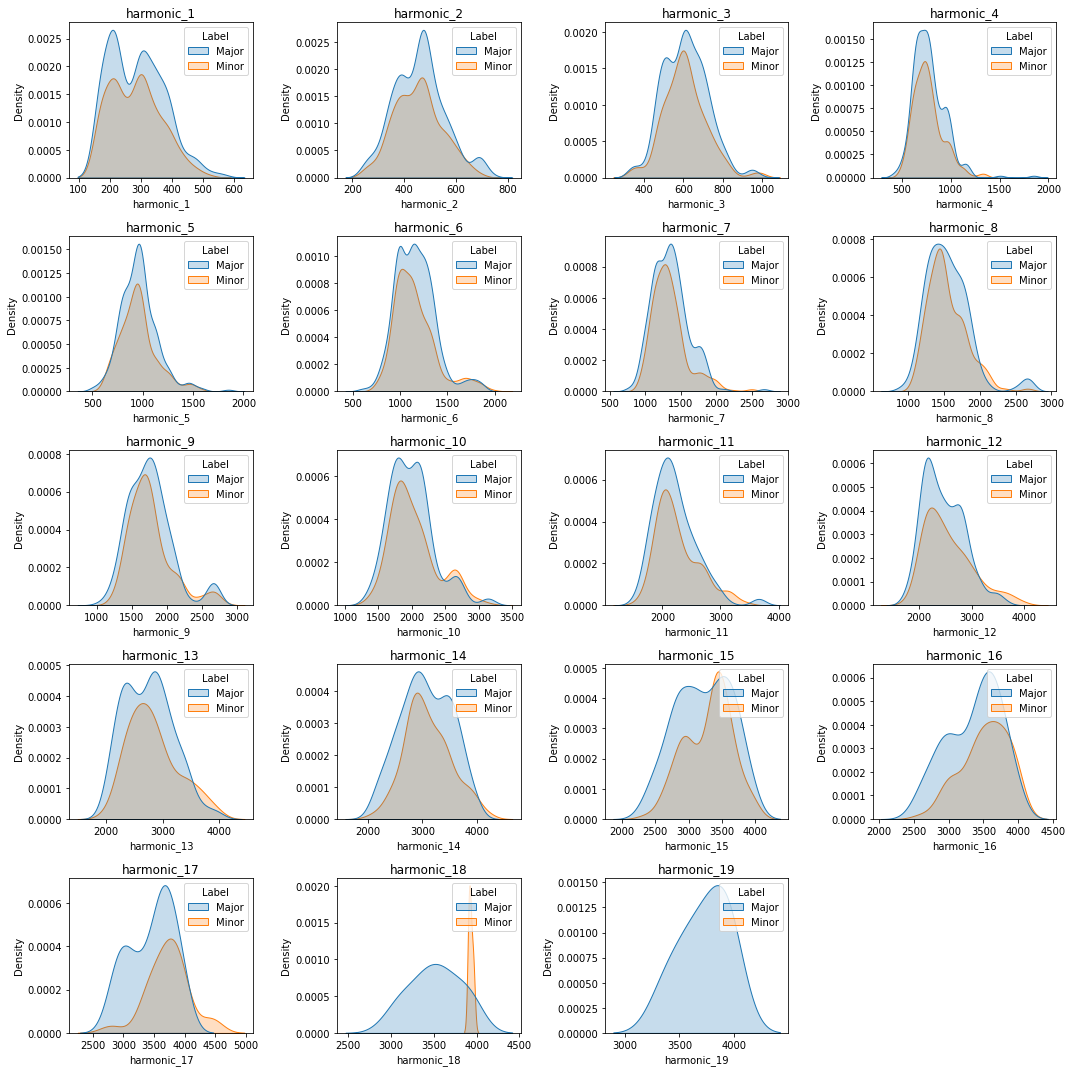

In [15]:
# Filter out columns that have zero variance
harmonic_columns_with_variance = [col for col in harmonic_columns if harmonics_df[col].var() > 0]

# Determine the number of columns and rows for plotting
num_cols = 4
num_rows = int(np.ceil(len(harmonic_columns_with_variance) / num_cols))

# Loop through each harmonic and plot the distributions
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 3))
axes = axes.flatten()  # Flatten axes for easier iteration

for i, col in enumerate(harmonic_columns_with_variance):
    sns.kdeplot(ax=axes[i], data=harmonics_df, x=col, hue="Label", fill=True)
    axes[i].set_title(col)

# Hide extra subplots if necessary
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.tight_layout()
plt.show()


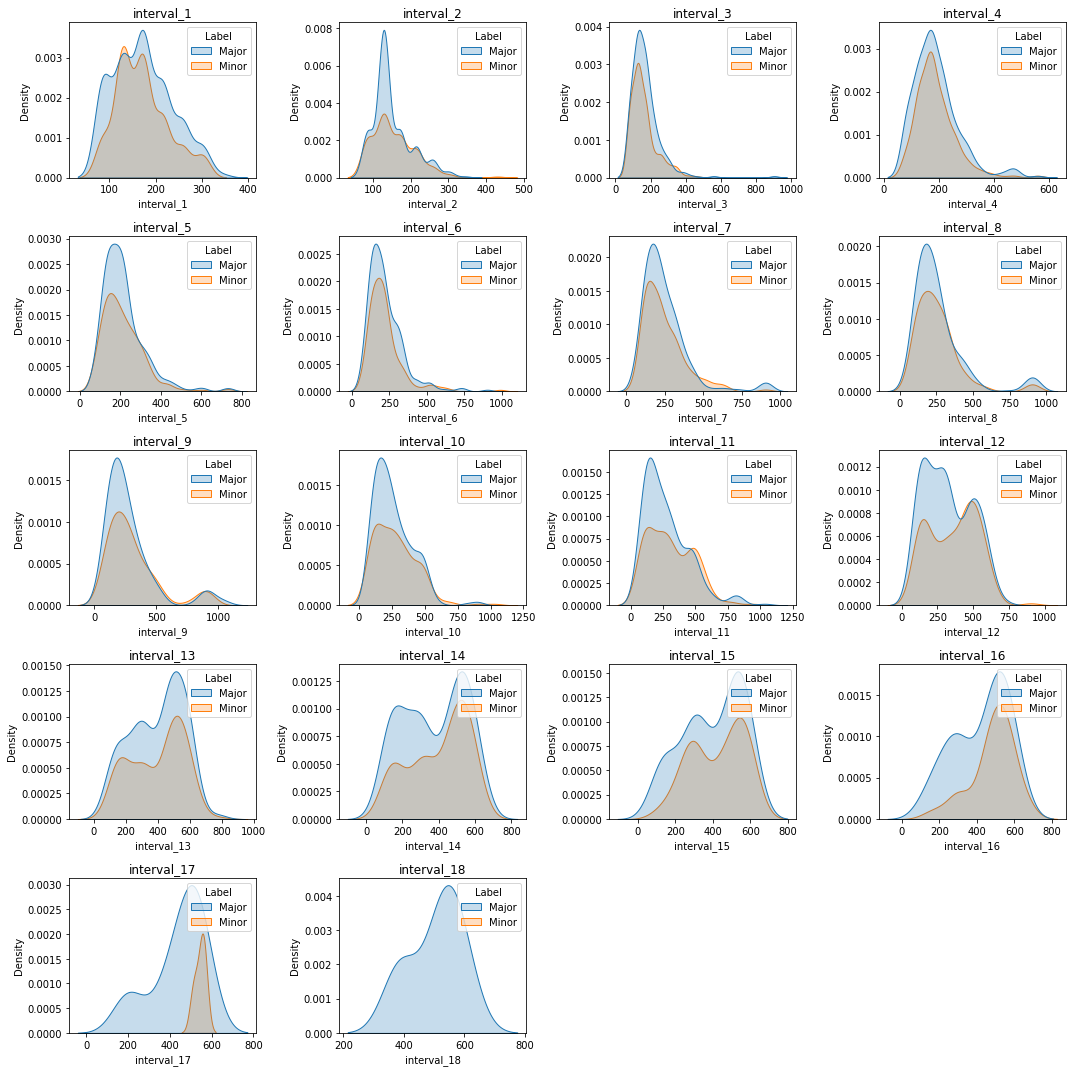

In [16]:
# Filter out interval columns that have zero variance
interval_columns_with_variance = [col for col in interval_columns if harmonics_df[col].var() > 0]

# Determine the number of columns and rows for plotting
num_cols = 4
num_rows = int(np.ceil(len(interval_columns_with_variance) / num_cols))

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 3))
axes = axes.flatten()

# Loop through each interval column and plot the distributions
for i, col in enumerate(interval_columns_with_variance):
    sns.kdeplot(ax=axes[i], data=harmonics_df, x=col, hue="Label", fill=True)
    axes[i].set_title(col)

# Hide extra subplots if necessary
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
fig.tight_layout()
plt.show()


In [17]:
# Define valid_columns to include all harmonic and interval columns
valid_columns = [col for col in harmonics_df.columns if 'harmonic_' in col or 'interval_' in col]

# Ensure only numeric columns are considered for NaN filling
numeric_columns = valid_columns  # valid_columns should only contain numeric data (harmonics + intervals)

# Fill NaN values with the column mean for the numeric columns only
harmonics_df_clean = harmonics_df.copy()  # Work on a copy of the original DataFrame
harmonics_df_clean[numeric_columns] = harmonics_df_clean[numeric_columns].fillna(harmonics_df[numeric_columns].mean())

# Programmatic Correlation Analysis
if not harmonics_df_clean.empty:
    correlations = harmonics_df_clean[numeric_columns].corrwith(harmonics_df_clean['Label'].astype('category').cat.codes)

    # Sort the correlations by absolute value to find the most important features
    sorted_correlations = correlations.abs().sort_values(ascending=False)
    print(sorted_correlations.head(10))  # Top 10 features
else:
    print("No valid data for correlation analysis.")


harmonic_17    0.094177
harmonic_16    0.085390
harmonic_12    0.077911
interval_12    0.074233
harmonic_13    0.062932
interval_16    0.059228
interval_11    0.059111
interval_3     0.054789
harmonic_18    0.053006
harmonic_15    0.050319
dtype: float64


In [18]:
# Suppress specific runtime warnings
warnings.filterwarnings("ignore", message="Degrees of freedom <= 0 for slice")
warnings.filterwarnings("ignore", message="divide by zero encountered in divide")

# Check if columns have no variance (either zero or NaN-filled) and remove them
valid_harmonic_columns = [col for col in harmonic_columns if harmonics_df[col].nunique() > 1]
valid_interval_columns = [col for col in interval_columns if harmonics_df[col].nunique() > 1]

# Combine valid columns for correlation analysis
valid_columns = valid_harmonic_columns + valid_interval_columns

# Fill NaN values with 0 to avoid issues in correlation (alternative: you could drop NaNs)
harmonics_df_clean = harmonics_df[valid_columns + ['Label']].fillna(0)

# Programmatic Correlation Analysis
if not harmonics_df_clean.empty:
    correlations = harmonics_df_clean[valid_columns].corrwith(harmonics_df_clean['Label'].astype('category').cat.codes)

    # Sort the correlations by absolute value to find the most important features
    sorted_correlations = correlations.abs().sort_values(ascending=False)
    print(sorted_correlations.head(10))  # Top 10 features
else:
    print("No valid data for correlation analysis.")

harmonic_18    0.082913
harmonic_19    0.076438
interval_17    0.076072
interval_18    0.075635
interval_9     0.055244
interval_3     0.054789
interval_11    0.042604
harmonic_8     0.038549
interval_2     0.037945
harmonic_10    0.035838
dtype: float64


`outdated`
#### Manual Inspection:

##### Harmonics:

Visually inspecting the plots for Harmonics and Intervals that might be more helpful in our model to distinguish chords, these are the harmonics with LESS overlay in Major / Minor chords (though, not by much!):

- harmonic_20
- harmonic_26
- harmonic_30

##### Intervals:
- interval_1
- interval_2
- interval_3
- interval_4
- interval_19
- interval_25
- interval_30

Other Notes:
- Interval 28 and 5 seem to have a similar shape, but different densities. Though, there is a small bit of non-overlap. This also applies for harmonic_26
- Interval 31 and 32 are both only charts with 'Major', meaning the 'Minor' data is either extremely small, or non-existant (likely the latter). I'm not sure whether we should use these quite yet. 

### Combined Analysis for Feature Engineering:

With our manual inspection and programatic correlation analysis, here is a final list of features:

- harmonic_20: Appears in both visual and correlation analysis.
- harmonic_26: Identified visually.
- harmonic_30: Strong in both visual and correlation analysis.
- harmonic_31: High correlation but not identified visually (worth testing).

##### Intervals:

- Interval 2, 3, 4, 19, 25: Visually identified
- Interval 30: Strong in both visual and correlation analysis.
- 
    Interval 27
    Interval 31: High correlation, but missing Minor data (requires further scrutiny).


## Ratios Between Specific Harmonics

While harmonic frequencies and intervals between them are useful, the way they relate to major vs minor chords could be more nuanced than just the interval values (like we are using). Major and minor chords differ mainly in the 3rd interval (major third vs minor third). We will focus on specific intervals or harmonic relationships that are known to differentiate major and minor chords.

We will compute the ratio between the 1st harmonic and the 3rd harmonic for each chord - and use that as a new feature. 

In [19]:
# List to hold the new harmonic ratio columns and their data
harmonic_ratio_data = []

# Get harmonic columns
harmonic_columns = [col for col in harmonics_df.columns if 'harmonic_' in col]

# Ensure there are at least 2 harmonic columns to calculate ratios
if len(harmonic_columns) > 1:
    for i in range(len(harmonic_columns)):
        for j in range(i + 1, len(harmonic_columns)):
            col_i = harmonic_columns[i]
            col_j = harmonic_columns[j]
            ratio_col_name = f'harmonic_ratio_{i}_to_{j}'  # Ensure "harmonic_ratio" is in the name
            
            # Calculate the ratio, avoiding division by zero
            harmonic_ratio = harmonics_df[col_i] / harmonics_df[col_j]
            harmonic_ratio.replace([np.inf, -np.inf], np.nan, inplace=True)  # Replace inf with NaN
            
            # Append the calculated ratios and column name to the list
            harmonic_ratio_data.append(harmonic_ratio.rename(ratio_col_name))
    
    # Concatenate all harmonic ratio columns at once to the DataFrame
    harmonic_ratio_df = pd.concat([harmonics_df] + harmonic_ratio_data, axis=1)

    # Fill NaN values with 0 or another appropriate value (depending on your analysis)
    harmonic_ratio_df.fillna(0, inplace=True)
    
    # Display the new DataFrame
    print(harmonic_ratio_df.head())
else:
    print("Not enough harmonic columns to compute ratios.")


          id  Label  harmonic_1  harmonic_2  harmonic_3  harmonic_4  \
0    Major_0  Major  258.146341  387.219512  516.292683  645.365854   
1    Major_1  Major  387.219512  516.292683  645.365854  774.439024   
2   Major_10  Major  258.146341  387.219512  516.292683  731.414634   
3  Major_100  Major  301.170732  387.219512  602.341463  774.439024   
4  Major_101  Major  301.170732  387.219512  688.390244  946.536585   

    harmonic_5   harmonic_6   harmonic_7   harmonic_8  ...  \
0   774.439024  1032.585366  1161.658537  1333.756098  ...   
1   989.560976  1161.658537  1333.756098  1979.121951  ...   
2   946.536585  1118.634146  1333.756098  1419.804878  ...   
3   946.536585  1118.634146  1376.780488  1548.878049  ...   
4  1118.634146  1247.707317  1548.878049     0.000000  ...   

   harmonic_ratio_16_to_17  harmonic_ratio_16_to_18  harmonic_ratio_16_to_19  \
0                      0.0                      0.0                      0.0   
1                      0.0              

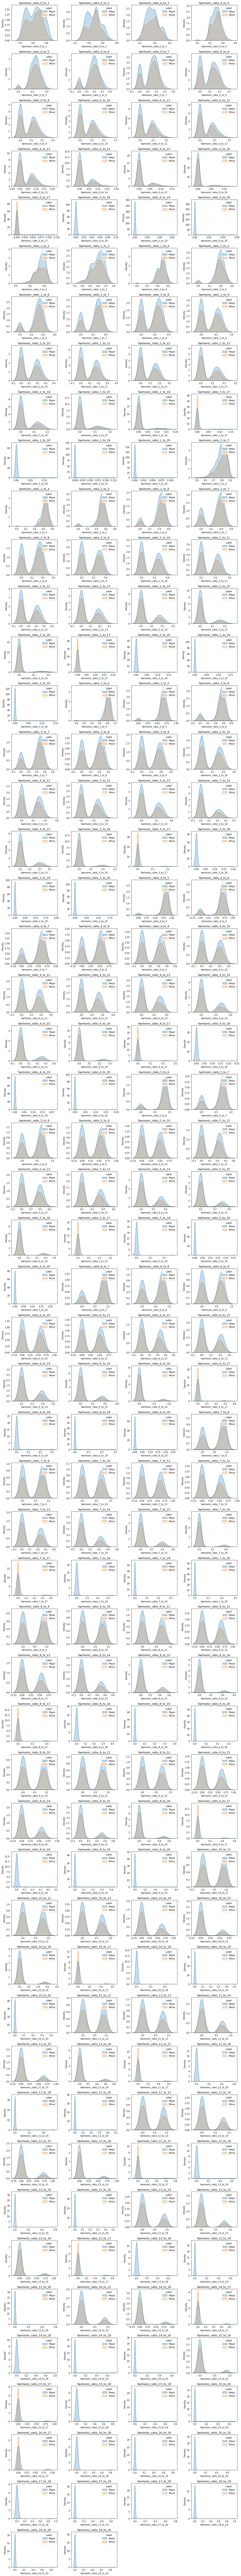

In [20]:
# Check for non-zero variance columns before plotting
harmonic_ratio_columns = [col for col in harmonic_ratio_df.columns if 'harmonic_ratio' in col]
non_zero_variance_columns = [col for col in harmonic_ratio_columns if harmonic_ratio_df[col].var() > 0]

if non_zero_variance_columns:
    # Set up a grid for plotting
    num_cols = 4
    num_rows = int(np.ceil(len(non_zero_variance_columns) / num_cols))

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 3))
    axes = axes.flatten()

    # Loop through each harmonic ratio column and plot the distribution
    for i, col in enumerate(non_zero_variance_columns):
        sns.kdeplot(ax=axes[i], data=harmonic_ratio_df, x=col, hue="Label", fill=True)
        axes[i].set_title(col)

    # Adjust layout and remove any extra subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    fig.tight_layout()
    plt.show()
else:
    print("No non-zero variance harmonic ratios to plot.")


In [21]:
# Check how many harmonic ratio columns are left
print(f"Number of harmonic ratio columns: {len(harmonic_ratio_columns)}")
print(harmonic_ratio_df[harmonic_ratio_columns].describe())


Number of harmonic ratio columns: 210
       harmonic_ratio_0_to_1  harmonic_ratio_0_to_2  harmonic_ratio_0_to_3  \
count             858.000000             858.000000             858.000000   
mean                0.622444               0.466644               0.369745   
std                 0.113781               0.095771               0.083135   
min                 0.400000               0.260870               0.190476   
25%                 0.500000               0.384615               0.312500   
50%                 0.636364               0.500000               0.357143   
75%                 0.714286               0.529412               0.421053   
max                 0.833333               0.692308               0.600000   

       harmonic_ratio_0_to_4  harmonic_ratio_0_to_5  harmonic_ratio_0_to_6  \
count             858.000000             858.000000             858.000000   
mean                0.296209               0.234853               0.180449   
std                 0.072

In [22]:
# Ensure harmonic ratio columns are included (for ratio columns only)
harmonic_ratio_columns_cleaned = [col for col in harmonic_ratio_df.columns if 'harmonic_ratio' in col]

# Exclude ratios involving harmonics 18, 19, or 20, as they only have Major data
harmonic_ratio_columns_filtered = [col for col in harmonic_ratio_columns_cleaned if not any(x in col for x in ['_18', '_19', '_20'])]

# Perform the correlation analysis for the filtered harmonic ratio columns only
if harmonic_ratio_columns_filtered:
    # Clean the DataFrame by removing any NaNs or infinities before running correlations
    harmonic_ratio_df_cleaned = harmonic_ratio_df[harmonic_ratio_columns_filtered + ['Label']].copy()

    # Convert 'Label' column to category codes (numeric)
    harmonic_ratio_df_cleaned['Label'] = harmonic_ratio_df_cleaned['Label'].astype('category').cat.codes

    # Fill NaN values with the column mean for numeric columns only
    harmonic_ratio_df_cleaned[harmonic_ratio_columns_filtered] = harmonic_ratio_df_cleaned[harmonic_ratio_columns_filtered].fillna(
        harmonic_ratio_df_cleaned[harmonic_ratio_columns_filtered].mean())

    # Calculate the correlations
    correlations = harmonic_ratio_df_cleaned[harmonic_ratio_columns_filtered].corrwith(harmonic_ratio_df_cleaned['Label'])

    # Sort the correlations by absolute value to find the most important ratio features
    sorted_correlations = correlations.abs().sort_values(ascending=False)

    # Display the top 10 most correlated harmonic ratios
    print("Top 20 most correlated harmonic ratios (excluding harmonics 18, 19, 20):")
    print(sorted_correlations.head(20))
else:
    print("No harmonic ratio columns found.")


Top 20 most correlated harmonic ratios (excluding harmonics 18, 19, 20):
harmonic_ratio_5_to_17     0.092158
harmonic_ratio_4_to_17     0.091626
harmonic_ratio_9_to_17     0.090984
harmonic_ratio_6_to_17     0.090934
harmonic_ratio_7_to_17     0.090927
harmonic_ratio_11_to_17    0.090647
harmonic_ratio_12_to_17    0.090623
harmonic_ratio_10_to_17    0.090054
harmonic_ratio_15_to_17    0.090026
harmonic_ratio_8_to_17     0.090018
harmonic_ratio_1_to_17     0.089793
harmonic_ratio_14_to_17    0.089715
harmonic_ratio_3_to_17     0.089609
harmonic_ratio_13_to_17    0.089420
harmonic_ratio_2_to_17     0.088992
harmonic_ratio_16_to_17    0.088454
harmonic_ratio_0_to_17     0.083612
harmonic_ratio_2_to_3      0.058351
harmonic_ratio_0_to_13     0.052026
harmonic_ratio_6_to_13     0.048877
dtype: float64


In [23]:
# Exclude ratios involving harmonics 17, 18, 19, or 20
harmonic_ratio_columns_filtered_no_17 = [col for col in harmonic_ratio_columns_cleaned if not any(x in col for x in ['_17', '_18', '_19', '_20'])]

# Perform the correlation analysis for the filtered harmonic ratio columns only
if harmonic_ratio_columns_filtered_no_17:
    # Clean the DataFrame by removing any NaNs or infinities before running correlations
    harmonic_ratio_df_cleaned_no_17 = harmonic_ratio_df[harmonic_ratio_columns_filtered_no_17 + ['Label']].copy()

    # Convert 'Label' column to category codes (numeric)
    harmonic_ratio_df_cleaned_no_17['Label'] = harmonic_ratio_df_cleaned_no_17['Label'].astype('category').cat.codes

    # Fill NaN values with the column mean for numeric columns only
    harmonic_ratio_df_cleaned_no_17[harmonic_ratio_columns_filtered_no_17] = harmonic_ratio_df_cleaned_no_17[harmonic_ratio_columns_filtered_no_17].fillna(
        harmonic_ratio_df_cleaned_no_17[harmonic_ratio_columns_filtered_no_17].mean())

    # Calculate the correlations
    correlations_no_17 = harmonic_ratio_df_cleaned_no_17[harmonic_ratio_columns_filtered_no_17].corrwith(harmonic_ratio_df_cleaned_no_17['Label'])

    # Sort the correlations by absolute value to find the most important ratio features
    sorted_correlations_no_17 = correlations_no_17.abs().sort_values(ascending=False)

    # Display the top 10 most correlated harmonic ratios (excluding harmonics 17, 18, 19, 20)
    print("Top 10 most correlated harmonic ratios (excluding harmonics 17, 18, 19, 20):")
    print(sorted_correlations_no_17.head(10))
else:
    print("No harmonic ratio columns found.")


Top 10 most correlated harmonic ratios (excluding harmonics 17, 18, 19, 20):
harmonic_ratio_2_to_3     0.058351
harmonic_ratio_0_to_13    0.052026
harmonic_ratio_6_to_13    0.048877
harmonic_ratio_3_to_13    0.048279
harmonic_ratio_4_to_13    0.047614
harmonic_ratio_2_to_13    0.046500
harmonic_ratio_8_to_13    0.045439
harmonic_ratio_7_to_13    0.045351
harmonic_ratio_5_to_13    0.045258
harmonic_ratio_6_to_7     0.044831
dtype: float64


Summary statistics for Harmonic Ratio 1/3 (Major vs Minor):
       count      mean       std       min       25%  50%       75%       max
Label                                                                        
Major  501.0  0.468444  0.097205  0.266667  0.384615  0.5  0.533333  0.692308
Minor  357.0  0.464118  0.093799  0.260870  0.400000  0.5  0.500000  0.666667


<ipython-input-24-36a025950615>:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  harmonic_ratio_df['harmonic_ratio_1_3'] = harmonic_ratio_1_3


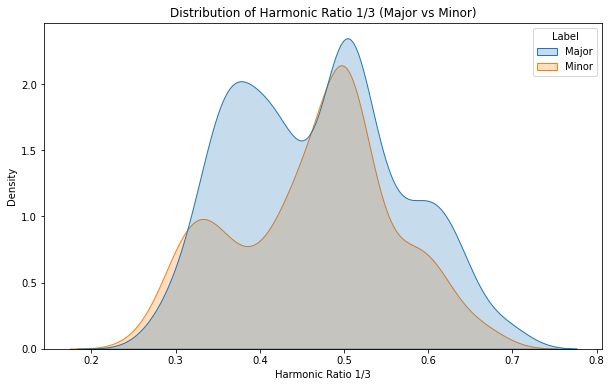

In [24]:
# a bit odd that all highly correlated harmonics include 17, and not 1 / 3 like I had predicted. 

# Check Harmonic 1/3 ratio and inspect the data for major and minor labels

# Calculate harmonic ratio 1/3
harmonic_ratio_1_3 = harmonic_ratio_df['harmonic_1'] / harmonic_ratio_df['harmonic_3']

# Add the harmonic ratio to the DataFrame if not already added
if 'harmonic_ratio_1_3' not in harmonic_ratio_df.columns:
    harmonic_ratio_df['harmonic_ratio_1_3'] = harmonic_ratio_1_3

# Summary statistics for Harmonic 1/3 ratio for both major and minor chords
print("Summary statistics for Harmonic Ratio 1/3 (Major vs Minor):")
print(harmonic_ratio_df.groupby('Label')['harmonic_ratio_1_3'].describe())

# Visualize the distribution of Harmonic Ratio 1/3 for both labels
plt.figure(figsize=(10, 6))
sns.kdeplot(data=harmonic_ratio_df, x='harmonic_ratio_1_3', hue='Label', fill=True)
plt.title("Distribution of Harmonic Ratio 1/3 (Major vs Minor)")
plt.xlabel("Harmonic Ratio 1/3")
plt.ylabel("Density")
plt.show()

In [25]:
# Exclude ratios involving harmonics 17, 18, 19, or 20 - potentially more generalizable
harmonic_ratio_columns_filtered_no_17_18_19_20 = [
    col for col in harmonic_ratio_columns_cleaned if not any(x in col for x in ['_17', '_18', '_19', '_20'])
]

# Perform the correlation analysis for the filtered harmonic ratio columns only
if harmonic_ratio_columns_filtered_no_17_18_19_20:
    # Clean the DataFrame by removing any NaNs or infinities before running correlations
    harmonic_ratio_df_cleaned_no_17_18_19_20 = harmonic_ratio_df[harmonic_ratio_columns_filtered_no_17_18_19_20 + ['Label']].copy()

    # Convert 'Label' column to category codes (numeric)
    harmonic_ratio_df_cleaned_no_17_18_19_20['Label'] = harmonic_ratio_df_cleaned_no_17_18_19_20['Label'].astype('category').cat.codes

    # Fill NaN values with the column mean for numeric columns only
    harmonic_ratio_df_cleaned_no_17_18_19_20[harmonic_ratio_columns_filtered_no_17_18_19_20] = harmonic_ratio_df_cleaned_no_17_18_19_20[harmonic_ratio_columns_filtered_no_17_18_19_20].fillna(
        harmonic_ratio_df_cleaned_no_17_18_19_20[harmonic_ratio_columns_filtered_no_17_18_19_20].mean())

    # Calculate the correlations
    correlations_no_17_18_19_20 = harmonic_ratio_df_cleaned_no_17_18_19_20[harmonic_ratio_columns_filtered_no_17_18_19_20].corrwith(harmonic_ratio_df_cleaned_no_17_18_19_20['Label'])

    # Sort the correlations by absolute value to find the most important ratio features
    sorted_correlations_no_17_18_19_20 = correlations_no_17_18_19_20.abs().sort_values(ascending=False)

    # Display the top 10 most correlated harmonic ratios (excluding harmonics 17, 18, 19, 20)
    print("Top 10 most correlated harmonic ratios (excluding harmonics 17, 18, 19, 20):")
    print(sorted_correlations_no_17_18_19_20.head(10))
else:
    print("No harmonic ratio columns found.")


Top 10 most correlated harmonic ratios (excluding harmonics 17, 18, 19, 20):
harmonic_ratio_2_to_3     0.058351
harmonic_ratio_0_to_13    0.052026
harmonic_ratio_6_to_13    0.048877
harmonic_ratio_3_to_13    0.048279
harmonic_ratio_4_to_13    0.047614
harmonic_ratio_2_to_13    0.046500
harmonic_ratio_8_to_13    0.045439
harmonic_ratio_7_to_13    0.045351
harmonic_ratio_5_to_13    0.045258
harmonic_ratio_6_to_7     0.044831
dtype: float64


In [31]:
# First, we will focus on the correlations for harmonics not involving 17 and higher - for a more generalizable model
# but we will include a couple of the top harmonic ratios involving 17 to see if they improve model performance

selected_harmonic_ratios = [ 'harmonic_ratio_2_to_3', 'harmonic_ratio_0_to_13', 
                            'harmonic_ratio_6_to_13', 'harmonic_ratio_3_to_13', 
                            'harmonic_ratio_4_to_13', 'harmonic_ratio_2_to_13', 
                            'harmonic_ratio_8_to_13', 'harmonic_ratio_7_to_13',
                            'harmonic_ratio_5_to_13', 'harmonic_ratio_6_to_7'
                           ]

### Other Audio Features



In [32]:
selected_harmonic_features = [ 'id',
    'harmonic_20', 'harmonic_26', 'harmonic_30', 'harmonic_31',
    'interval_1', 'interval_2', 'interval_3', 'interval_4', 'interval_19', 
    'interval_25', 'interval_30', 'interval_27', 'interval_31'
]

---

# Modeling

This is a classification problem, with the goal of predicting whether a chord is major or minor. The initial plan is to use a basic model like logistic regression or SVM as a baseline. After extracting features like MFCCs or spectrograms, we will establish the baseline and then experiment with more advanced models like convolutional neural networks (CNNs) to improve accuracy.

### Data Prep before modeling:

Audio Features dataframe with selected harmonic features

features_df

In [42]:
print(harmonics_df.columns)


Index(['id', 'Label', 'harmonic_1', 'harmonic_2', 'harmonic_3', 'harmonic_4',
       'harmonic_5', 'harmonic_6', 'harmonic_7', 'harmonic_8', 'harmonic_9',
       'harmonic_10', 'harmonic_11', 'harmonic_12', 'harmonic_13',
       'harmonic_14', 'harmonic_15', 'harmonic_16', 'harmonic_17',
       'harmonic_18', 'harmonic_19', 'harmonic_20', 'harmonic_21',
       'interval_1', 'interval_2', 'interval_3', 'interval_4', 'interval_5',
       'interval_6', 'interval_7', 'interval_8', 'interval_9', 'interval_10',
       'interval_11', 'interval_12', 'interval_13', 'interval_14',
       'interval_15', 'interval_16', 'interval_17', 'interval_18',
       'interval_19', 'interval_20'],
      dtype='object')


In [43]:
# Fill NaN values in harmonic_ratio_df with 0
# harmonics_df.loc[:, harmonic_columns] = harmonics_df[harmonic_columns].fillna(0)

# First, let's filter out any non-existing columns from the list of selected harmonic features
valid_harmonic_features = [col for col in selected_harmonic_features if col in harmonics_df.columns]

# Drop 'id' from harmonics_df (since we already have it in harmonic_ratio_df)
harmonics_df_cleaned = harmonics_df[valid_harmonic_features + ['Label']].copy()

# Merge harmonic ratios and harmonic features based on 'id'
combined_df = pd.merge(harmonic_ratio_df[['id'] + selected_harmonic_ratios], 
                       harmonics_df_cleaned,
                       on='id', how='inner')

# Display the merged dataframe to verify it's correct
print(combined_df.head())

          id  harmonic_ratio_2_to_3  harmonic_ratio_0_to_13  \
0    Major_0               0.800000                0.082192   
1    Major_1               0.833333                0.000000   
2   Major_10               0.705882                0.000000   
3  Major_100               0.777778                0.089744   
4  Major_101               0.727273                0.000000   

   harmonic_ratio_6_to_13  harmonic_ratio_3_to_13  harmonic_ratio_4_to_13  \
0                0.369863                0.205479                0.246575   
1                0.000000                0.000000                0.000000   
2                0.000000                0.000000                0.000000   
3                0.410256                0.230769                0.282051   
4                0.000000                0.000000                0.000000   

   harmonic_ratio_2_to_13  harmonic_ratio_8_to_13  harmonic_ratio_7_to_13  \
0                0.164384                0.506849                0.424658   
1   

In [47]:
# Encode the 'Label' column (Major/Minor) as integers
label_encoder = LabelEncoder()
y = combined_df['Label']
y_encoded = label_encoder.fit_transform(y)

# Define features (X) and target (y)
X = combined_df.drop(columns=['Label', 'id'])  # Drop 'Label' and 'id' from features
y = combined_df['Label']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

In [48]:
# Train a RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predict on the test set
y_pred = rf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 76.16%


---

## Evaluation

To evaluate the model, we will use metrics such as accuracy, precision, recall, and F1-score, focusing on correctly classifying both major and minor chords. The minimum viable product (MVP) will involve building a baseline model (e.g., logistic regression or SVM) to classify the chords with reasonable accuracy. Stretch goals include improving the model using more complex techniques like CNNs or RNNs, and addressing any data imbalances to achieve better generalization and robustness.

In [49]:
# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

       Major       0.77      0.81      0.79        97
       Minor       0.74      0.69      0.72        75

    accuracy                           0.76       172
   macro avg       0.76      0.75      0.76       172
weighted avg       0.76      0.76      0.76       172

Confusion Matrix:
[[79 18]
 [23 52]]


---

# Deployment

The results will be delivered through a simple Streamlit web app, where users can upload or record audio files to classify as major or minor chords. The app will provide real-time feedback, displaying the classification result along with confidence scores and visualizations such as waveforms or spectrograms. The app will be hosted on Streamlit Cloud, making it easily accessible and user-friendly for quick chord analysis.